# System Tests and Development

In [1]:
%matplotlib widget
from SDMRR import *
import scipy.signal as sg
import time
import matplotlib.pyplot as plt
from pump import *
import RPi.GPIO as GPIO

## Initialize the MRR
mrr = SDMRR(nocal=True)

Loading Calibration Data
Last Calibration: Fri Jun 16 13:11:19 2023


[INFO] [UHD] linux; GNU C++ version 11.3.0; Boost_107800; UHD_4.4.0.HEAD-release
[INFO] [B200] Detected Device: B210
[INFO] [B200] Operating over USB 3.
[INFO] [B200] Initialize CODEC control...
[INFO] [B200] Initialize Radio control...
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Setting master clock rate selection to 'automatic'.
[INFO] [B200] Asking for clock rate 16.000000 MHz... 
[INFO] [B200] Actually got clock rate 16.000000 MHz.


In [2]:
peri = Pump()
peri.setdir(1, 'cw')
peri.setspeed(1, 50)
peri.start(2)

In [3]:
import RPi.GPIO as GPIO# Choose a probe
GPIO.setmode(GPIO.BCM)
GPIO.setup(15, GPIO.OUT)
GPIO.setup(14, GPIO.OUT)
GPIO.output(14, GPIO.LOW)
GPIO.output(15, GPIO.HIGH)

/tmp/ipykernel_23404/1569962910.py:3: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(15, GPIO.OUT)
/tmp/ipykernel_23404/1569962910.py:4: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(14, GPIO.OUT)


In [4]:
GPIO.output(14, GPIO.HIGH)
GPIO.output(15, GPIO.LOW)

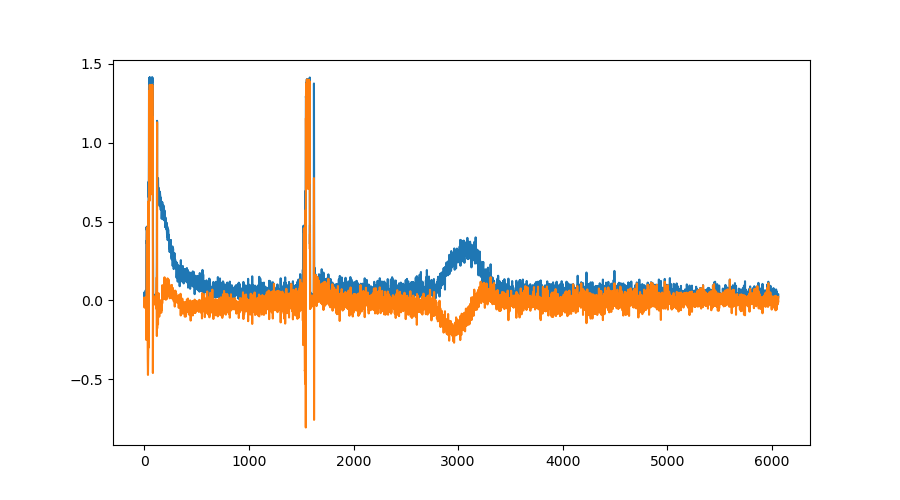

In [14]:
mrr.RX_GAIN = 30
# mrr.cal(t90 = 0.00006, f0=22100000)

try: fidfig
except NameError: pass
else: plt.close(fidfig)
GPIO.output(15, GPIO.HIGH)
GPIO.output(14, GPIO.LOW)
mrr.cal(t90 = 0.00006, f0=22055500.0)
peri.stop(2)
time.sleep(0.5)
p90 = 0.3
fid = mrr.pulseecho(t90 = 0.00006, gain=70, amp90=p90, amp180=p90*2)

# time.sleep(4)
# fid = mrr.onepulse(filt=False, gain=70, amp = 0.1)
fidfig = plt.figure(figsize=(9,5))
plt.plot(np.abs(fid))
plt.plot(np.imag(fid))
plt.show()
peri.start(2)

In [6]:
def find_t90(t90 = None, f0 = None, gain = 70, debug = False):
    if f0 is None:
        f0 = mrr.caldict["f0"]
        
    if t90 is None:
        t90 = mrr.caldict["t90"]

    if debug:
        print("Calibrating t90")

    def _weight(fid):
        return np.average(np.abs(fid[80:120]))

    powers = np.linspace(0, 1, 20)
    scores = np.zeros(len(powers))
    for i in range(len(powers)):
        fidstart_idx = 355 #extra 500 for lowpass filter
        if debug:
            print("Testing %f" % (powers[i]))
        fid = mrr.pulseecho(t90 = 0.00009, gain=70, amp90=powers[i], amp180=0.9)
        scores[i] = _weight(fid)
        if debug:
            print(scores[i])
        time.sleep(3)
    return np.stack((powers, scores), axis=1)

In [198]:
find_t90()

KeyboardInterrupt: 

In [6]:
GPIO.output(14, GPIO.HIGH)
GPIO.output(15, GPIO.LOW)
peri.stop(1)
mrr.RX_GAIN = 30
mrr.cal(t90 = 0.00009, f0=22063000.0)
caldata = find_t90(debug = True, gain= 70)

calfig = plt.figure()
plt.plot(caldata[:,0], caldata[:,1])
plt.show()

NameError: name 'find_t90' is not defined

In [5]:
def gett2(save = False, amp90 = 0.45, amp180 = 0.9, npulses = 5000, threshold = 1000, directory = None):
    
    print("CPMG")
    npulses = npulses
    tr = 500.023e-6
    
    cp = mrr.cpmg_phaseloop(npulses = npulses, cycle_90 = [0], cycle_180 = [1], amp90 = amp90, amp180 = amp180, raw = True) #
    
    #Get echo amplitudes
    width = 200
    threshold = threshold
    tr_samps = tr*mrr.FS
    t90_samps = int(mrr.caldict['t90'] * mrr.FS)
    mags_abs = np.zeros(npulses)
    mags_r = np.zeros(npulses)

    for i in range(npulses):
        start = int((i+1) * tr_samps - width/2) + t90_samps
        mags_abs[i] = np.average(np.sum(np.abs(cp[:,start:start+width]),axis=0))

    cfig = plt.figure(figsize=(9,5))
    plt.plot(mags_abs)
    plt.legend([str(mrr.caldict['f0'])])
    t2 = mrr.get_t2(mags_abs[threshold:], tr=500.023e-6)
    plt.xlabel("T2 = " + str(t2))
    # plt.savefig(directory + "Figures/cpmg" + datetime.datetime.now().isoformat() + ".png")
    plt.show()
    
    # if(save):
    #     np.save(directory + datetime.datetime.now().isoformat() + '.npy', cp, allow_pickle=True)
    #     # np.save("/media/sdmrr/XDrive/Data/" + datetime.datetime.now().isoformat() + '.npy', cp, allow_pickle=True)
    # print("T2: %0.2f" %  (t2))
    return t2

CPMG
0


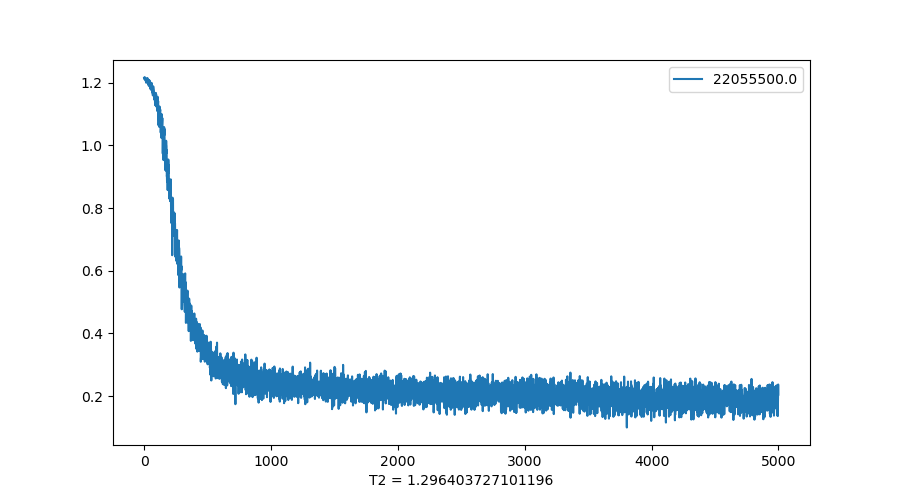

In [21]:
peri.stop(2)
time.sleep(2)
# mrr.RX_GAIN = 30
GPIO.output(15, GPIO.HIGH)
GPIO.output(14, GPIO.LOW)
mrr.cal(t90 = 0.00006, f0=22055500.0)
# # pe = mrr.pulseecho(t90 = 0.00009, gain=68, amp90=0.153, amp180=0.525)
# t2 = gett2(save=False, amp90 = 0.30, amp180 = 0.60, npulses = 400, threshold = 0)
# t2 = gett2(save=False, amp90 = 0.30, amp180 = 0.60, npulses = 400, threshold = 0)
mrr.RX_GAIN = 50
# mrr.pulseecho(t90 = 0.00006, gain=70, amp90=p90, amp180=p90*2)
t2_norm = gett2(save=False, amp90 = 0.31, amp180 = 0.5)
peri.start(2)

In [31]:
t2

1.469094058445448

CPMG
0


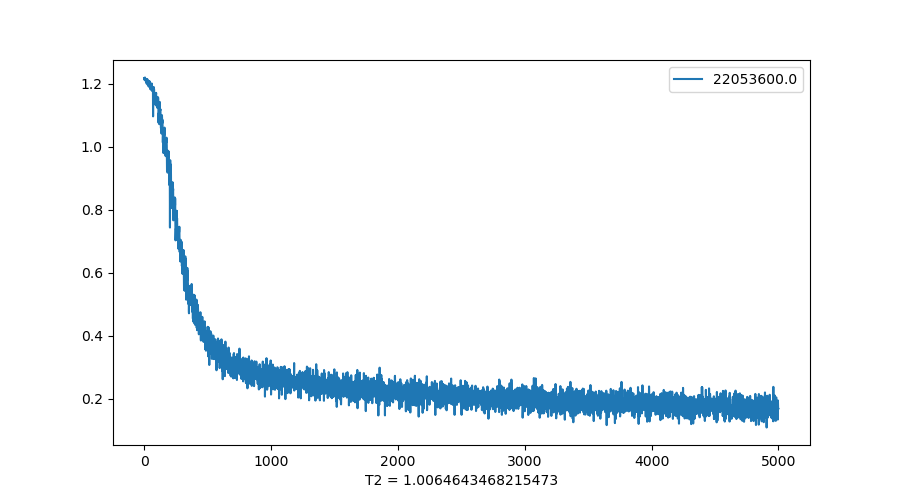

In [40]:
peri.stop(2)
time.sleep(0.5)
mrr.RX_GAIN = 50
GPIO.output(14, GPIO.LOW)
GPIO.output(15, GPIO.HIGH)
mrr.cal(t90 = 0.00006, f0=22053600.0)
# pe = mrr.pulseecho(t90 = 0.00009, gain=68, amp90=0.153, amp180=0.525)
t2 = gett2(save=False, amp90 = 0.275, amp180 = 0.55, directory = "/media/sdmrr/XDrive1/CHO_Data/")
peri.start(2)

0


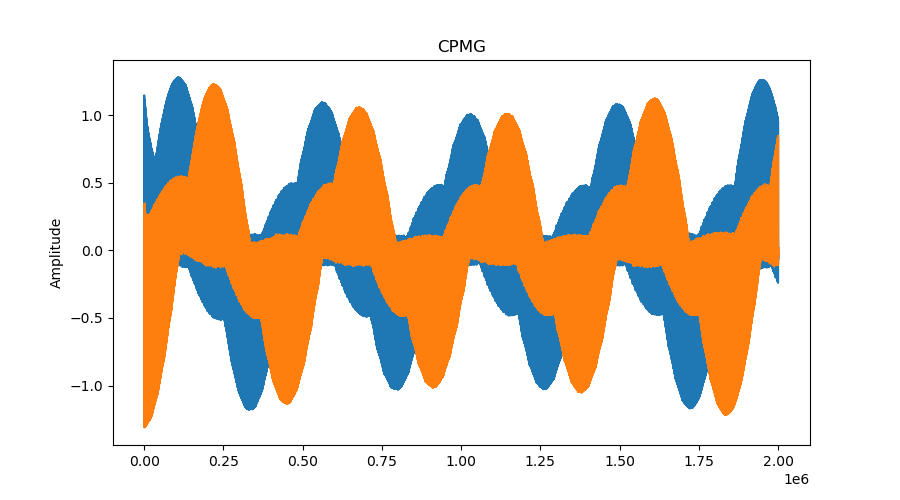

In [36]:
%matplotlib widget
try: cpfig
except NameError: pass
else: plt.close(cpfig)
mrr.caldict['t90'] = 0.00

mrr.FS = 1e6
mrr.RX_GAIN = 35
GPIO.output(15, GPIO.HIGH)
GPIO.output(14, GPIO.LOW)
mrr.cal(t90 = 0.00009, f0=22065500.0)
tr = 500.023e-6
npulses = 4000
cycle = [1,1,1,1]

phase_cycle_180 = [1]#,1,3,3]
phase_cycle_90 = [0]#,2,0,2]

#"Cycle 90: 0,2,0,2,1,3,1,3, Cycle 180: 1,1,3,3,0,0,2,2"

cpfig = plt.figure(figsize=(9,5))
explen = int(((npulses + 1) * tr + mrr.caldict["t90"])*mrr.FS)
cpdatas = np.zeros(explen, dtype=np.complex64)

# peri.stop()
time.sleep(2)

for i in range(len(phase_cycle_180)):
    cpdata = mrr.ncpmg(gain = 70, tr=tr, npulses=npulses, cycle=[phase_cycle_180[i] for j in range(4)], width=4, p90p = phase_cycle_90[i], amp90=0.32, amp180=0.64)
    eshift = -np.angle(np.average(cpdata[60:80]))   #phase properly
    cpdatas += cpdata*np.exp(1j*eshift)
    print(i)
    time.sleep(3)
    
# peri.start()

plt.plot(np.real(cpdata))
plt.plot(np.imag(cpdata))

#plt.xlim([0,35000])
    
#plt.legend([str(cycle)])
plt.title("CPMG")
plt.ylabel("Amplitude")
plt.show()

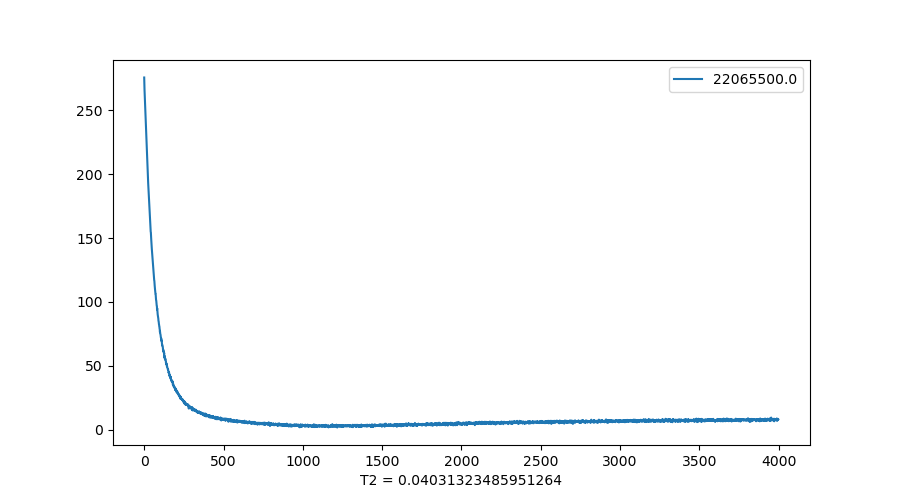

In [37]:
#Get echo amplitudes
width = 250
threshold = 1
tr_samps = tr*mrr.FS
t90_samps = int(mrr.caldict['t90'] * mrr.FS)
mags_abs = np.zeros(npulses)
mags_r = np.zeros(npulses)

for i in range(npulses):
    start = int((i+1) * tr_samps - width/2) + t90_samps
    mags_abs[i] = np.average(np.sum(np.abs(cpdata[start:start+width]),axis=0))

cfig = plt.figure(figsize=(9,5))
plt.plot(mags_abs[threshold:])
plt.legend([str(mrr.caldict['f0'])])
t2 = mrr.get_t2(mags_abs[threshold:], tr=500.2e-6)
plt.xlabel("T2 = " + str(t2))
# plt.savefig(directory + "Figures/cpmg" + datetime.datetime.now().isoformat() + ".png")
plt.show()

In [13]:


def find_f0(t90 = None, gain = 70, freq = None):
    if freq is None:
        freq = mrr.caldict["f0"]
    if t90 is None:
        t90 = mrr.caldict["t90"]

    echo = mrr.pulseecho(gain=70, amp90=0.45, amp180=0.9)[2000:4000]
    efft = np.fft.fft(echo)

    ftfreqs = np.fft.fftfreq(4000, mrr.FS)
    maxfreq = ftfreqs[np.argmax(np.fft.fftshift(np.abs(efft)))-2000]
    f0 = freq + maxfreq

    return f0

[INFO] [B200] Asking for clock rate 32.000000 MHz... 
[INFO] [B200] Actually got clock rate 32.000000 MHz.


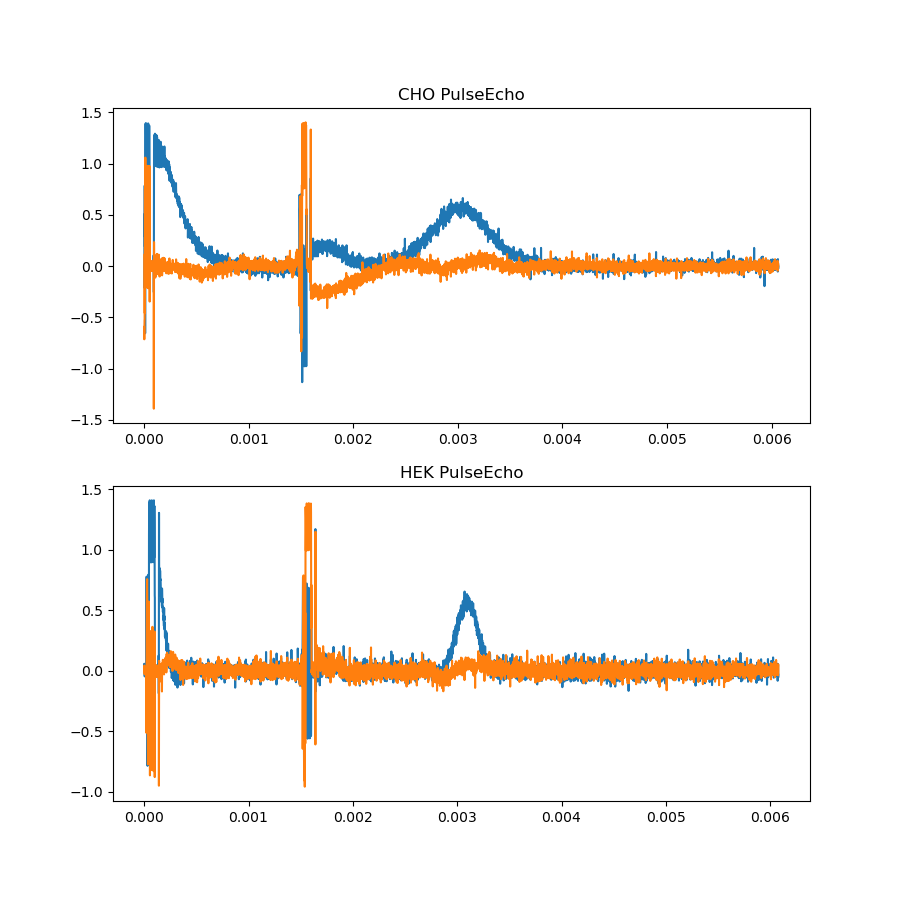

In [4]:
try: pefig
except NameError: pass
else: plt.close(pefig)

mrr.RX_GAIN = 35

peri.stop(1)
# time.sleep(1)

mrr.FS = 1e6
GPIO.output(15, GPIO.HIGH)
GPIO.output(14, GPIO.LOW)
mrr.cal(t90 = 0.000065, f0=22065500.0)
pe = mrr.pulseecho(gain=70, amp90=0.45, amp180=0.90)
# pe = onepulse(t90 = 0.00006, gain=70, amp90=0.45)
pefig, ax = plt.subplots(2,1,figsize=(9,9))
ax[0].plot(np.arange(len(pe))*1/mrr.FS, np.real(pe))
ax[0].plot(np.arange(len(pe))*1/mrr.FS, np.imag(pe))
ax[0].set_title("CHO PulseEcho")

GPIO.output(14, GPIO.HIGH)
GPIO.output(15, GPIO.LOW)
mrr.cal(t90 = 0.000079, f0=22060300)
pe = mrr.pulseecho(gain=70, amp90=0.3, amp180=0.8)
# pe = onepulse(t90 = 0.00006, gain=70, amp90=0.45)
ax[1].plot(np.arange(len(pe))*1/mrr.FS, np.real(pe))
ax[1].plot(np.arange(len(pe))*1/mrr.FS, np.imag(pe))
ax[1].set_title("HEK PulseEcho")
plt.show()
# peri.start(1)

In [10]:
GPIO.output(15, GPIO.HIGH)
GPIO.output(14, GPIO.LOW)